# Enhanced GeoZarr for EOPF: Full Multiscale Zarr V3 Store with RGB Visualization and Performance Analysis

This enhanced notebook demonstrates how to transform EOPF Zarr stores into complete GeoZarr V3 compliant datasets with:

- **Full EOPF structure preservation**: All resolution groups and variables
- **Complete multiscale support**: COG-style overviews for all bands
- **Enhanced visualization**: RGB composite plots using overview levels
- **Data access analysis**: Overview loading time and resolution comparison
- **Modular code organization**: Most functionality moved to helper module

Following COG conventions, the overviews maintain native projection and use /2 downsampling logic.

## Setup and Data Loading

First, we'll import required libraries and set up our environment. We're using the experimental Zarr V3 API for enhanced functionality and compatibility.

In [30]:
import os
os.environ["ZARR_V3_EXPERIMENTAL_API"] = "1"

import json
import cf_xarray  # noqa
import dask.array as da
import matplotlib.pyplot as plt
import morecantile
import numpy as np
import panel
import rasterio
import numcodecs
import rioxarray  # noqa
import xarray as xr
import zarr
import dask
import time
from rio_tiler.io.xarray import XarrayReader

from geozarr_examples.cog_multiscales import (
    setup_eopf_metadata,
    create_full_eopf_zarr_store,
    plot_rgb_overview,
    get_sentinel2_rgb_bands,
    verify_overview_coordinates,
    plot_overview_levels
)

### Configuration

Set up paths and parameters for our data processing:
- `spatial_chunk`: Size of spatial chunks for efficient data access
- `min_dimension`: Minimum size for overview levels
- `tileWidth`: Base tile width for TMS compatibility

In [31]:
# Set up paths and parameters
fp_base = "S2B_MSIL1C_20250113T103309_N0511_R108_T32TLQ_20250113T122458"
input_url = f"https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_v253/{fp_base}.zarr"
v3_output = f"../output/v3/{fp_base}_full_multiscales.zarr"

spatial_chunk = 4096  # Size of spatial chunks
min_dimension = 256   # Minimum dimension for overviews
tileWidth = 256      # Base tile width

### Setting up Dask Client

Initialize a Dask client for parallel processing capabilities. This will help with processing large datasets efficiently.

In [32]:
from dask.distributed import Client
client = Client()  # set up local cluster
client

/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/.venv/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41299 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:43015' processes=11 threads=22, memory=62.24 GiB>

### Loading the EOPF Data

Load the Earth Observation Processing Framework (EOPF) data from the remote Zarr store. This data follows the EOPF structure with multiple resolution groups.

In [33]:
# Load the EOPF DataTree
dt = xr.open_datatree(input_url, engine="zarr", chunks={})
print("EOPF DataTree structure:")
print(dt)

/tmp/ipykernel_978013/1148099201.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dt = xr.open_datatree(input_url, engine="zarr", chunks={})
/tmp/ipykernel_978013/1148099201.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64

EOPF DataTree structure:
<xarray.DataTree>
Group: /
│   Attributes:
│       other_metadata:   {'L0_ancillary_data_quality': 'null', 'L0_ephemeris_dat...
│       other_metadata4:  {'L0_ancillary_data_quality': 'null', 'L0_ephemeris_dat...
│       stac_discovery:   {'assets': {'analytic': {'eo:bands': [{'center_waveleng...
├── Group: /conditions
│   ├── Group: /conditions/geometry
│   │       Dimensions:                        (angle: 2, band: 13, y: 23, x: 23,
│   │                                           detector: 7)
│   │       Coordinates:
│   │         * angle                          (angle) <U7 56B 'zenith' 'azimuth'
│   │         * band                           (band) <U3 156B 'b01' 'b02' ... 'b11' 'b12'
│   │         * detector                       (detector) int64 56B 6 7 8 9 10 11 12
│   │         * x                              (x) int64 184B 300000 305000 ... 410000
│   │         * y                              (y) int64 184B 5000040 4995040 ... 4890040
│   │       Dat

## Creating the Enhanced GeoZarr Store

Now we'll create a full EOPF Zarr store with multiscales. This process:
1. Preserves all resolution groups (r10m, r20m, r60m)
2. Sets up proper CF metadata and CRS information
3. Creates COG-style overview levels for all bands
4. Collects timing data for performance analysis

The `create_full_eopf_zarr_store` function handles this transformation while maintaining the original EOPF structure.

In [34]:
# Create the full EOPF Zarr store with multiscales
print("Creating full EOPF Zarr store with multiscales...")
print("This will process all resolution groups and create overview levels for all bands.")
print("This may take several minutes depending on data size and number of bands.")

try:
    # Create store and proceed with timing analysis
    result = create_full_eopf_zarr_store(
        dt=dt,
        output_path=v3_output,
        spatial_chunk=spatial_chunk,
        min_dimension=min_dimension,
        tileWidth=tileWidth,
        load_data=False,  # Use lazy loading for large datasets
        max_retries=3     # Retry failed operations
    )
    print("\n✅ Full EOPF Zarr store created successfully!")
    
except Exception as e:
    print(f"\n❌ Failed: {e}")
    raise

Creating full EOPF Zarr store with multiscales...
This will process all resolution groups and create overview levels for all bands.
This may take several minutes depending on data size and number of bands.
Processing group: /measurements/reflectance/r10m
  Processing band: b02
    Setting CRS for b02 to EPSG:32632
  Processing band: b03
    Setting CRS for b03 to EPSG:32632
  Processing band: b04
    Setting CRS for b04 to EPSG:32632
  Processing band: b08
    Setting CRS for b08 to EPSG:32632
Processing group: /measurements/reflectance/r20m
  Processing band: b05
    Setting CRS for b05 to EPSG:32632
  Processing band: b06
    Setting CRS for b06 to EPSG:32632
  Processing band: b07
    Setting CRS for b07 to EPSG:32632
  Processing band: b11
    Setting CRS for b11 to EPSG:32632
  Processing band: b12
    Setting CRS for b12 to EPSG:32632
  Processing band: b8a
    Setting CRS for b8a to EPSG:32632
Processing group: /measurements/reflectance/r60m
  Processing band: b01
    Setting CR

/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  level_ds = xr.open_zarr(overview_path, group=level_str, zarr_format=3)
/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warnin

✅ Found existing overviews for /measurements/reflectance/r10m/b02
✅ Found existing overviews for /measurements/reflectance/r10m/b03
✅ Found existing data for /measurements/reflectance/r20m


/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  level_ds = xr.open_zarr(overview_path, group=level_str, zarr_format=3)
/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warnin

✅ Found existing overviews for /measurements/reflectance/r20m/b05
✅ Found existing overviews for /measurements/reflectance/r20m/b12
✅ Found existing overviews for /measurements/reflectance/r20m/b07
✅ Found existing overviews for /measurements/reflectance/r20m/b8a


/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  level_ds = xr.open_zarr(overview_path, group=level_str, zarr_format=3)
/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warnin

✅ Found existing overviews for /measurements/reflectance/r20m/b11
✅ Found existing overviews for /measurements/reflectance/r20m/b06
✅ Found existing data for /measurements/reflectance/r60m
✅ Found existing overviews for /measurements/reflectance/r60m/b01
✅ Found existing overviews for /measurements/reflectance/r60m/b09
✅ Found existing overviews for /measurements/reflectance/r60m/b10
🎉 All data already exists! Returning existing results.

✅ Full EOPF Zarr store created successfully!


/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  level_ds = xr.open_zarr(overview_path, group=level_str, zarr_format=3)
/home/emathot/Workspace/DevelopmentSeed/geozarr-examples/src/geozarr_examples/cog_multiscales.py:612: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warnin

## Overview Generation Timing Analysis

Let's analyze the timing data for generating overviews across different resolution groups and bands. This measures the time taken to create the downsampled overview levels:

In [35]:
# Analyze timing data from overview creation
for group_name, group_overviews in result['overview_levels'].items():
    print(f"\n=== Performance Analysis for {group_name} ===\n")
    
    for var, var_data in group_overviews.items():
        if 'timing' in var_data:
            timing_data = var_data['timing']
            print(f"\nAnalyzing {var}:")
            print(f"{'Level':>6} {'Scale':>8} {'Pixels':>12} {'Time (s)':>10} {'MP/s':>10}")
            print("-" * 50)
            
            for timing in timing_data:
                level = timing['level']
                pixels = timing['pixels']
                proc_time = timing['time']
                megapixels = pixels / 1e6
                mp_per_second = megapixels / proc_time if proc_time > 0 else 0
                
                print(f"{level:6d} {timing['scale_factor']:8d} {pixels:12,d} {proc_time:10.2f} {mp_per_second:10.2f}")
            
            # Create a performance plot for this variable
            plt.figure(figsize=(10, 6))
            levels = [t['level'] for t in timing_data]
            times = [t['time'] for t in timing_data]
            pixels = [t['pixels'] for t in timing_data]
            
            # Plot processing time
            ax1 = plt.gca()
            line1 = ax1.plot(levels, times, 'b-o', label='Processing Time')
            ax1.set_xlabel('Overview Level')
            ax1.set_ylabel('Processing Time (s)', color='b')
            ax1.tick_params(axis='y', labelcolor='b')
            
            # Plot pixel count on secondary y-axis
            ax2 = ax1.twinx()
            line2 = ax2.plot(levels, pixels, 'r-s', label='Pixel Count')
            ax2.set_ylabel('Pixel Count', color='r')
            ax2.tick_params(axis='y', labelcolor='r')
            
            # Add legend
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax1.legend(lines, labels, loc='upper right')
            
            plt.title(f'Overview Creation Performance: {group_name}/{var}')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()


=== Performance Analysis for /measurements/reflectance/r10m ===


=== Performance Analysis for /measurements/reflectance/r20m ===


=== Performance Analysis for /measurements/reflectance/r60m ===



## Data Access and Visualization Performance

Now we'll analyze how different overview levels affect data loading and visualization:
1. Data access time (loading from storage)
2. Memory requirements (through pixel count)
3. Visual quality vs performance trade-off

This analysis helps understand how overview levels impact the speed of accessing and displaying data, guiding the choice of appropriate levels for interactive visualization.

### RGB Overview Access Performance

First, let's measure how quickly we can load and display RGB composites at different overview levels. The timing shows data access and visualization speed:

Using /measurements/reflectance/r10m for RGB visualization
RGB bands: R=b04, G=b03, B=b02


/tmp/ipykernel_978013/2360455945.py:35: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr(f"{v3_output}/{rgb_group}/{red_band}_overviews", group=str(i))
/tmp/ipykernel_978013/2360455945.py:37: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly sett

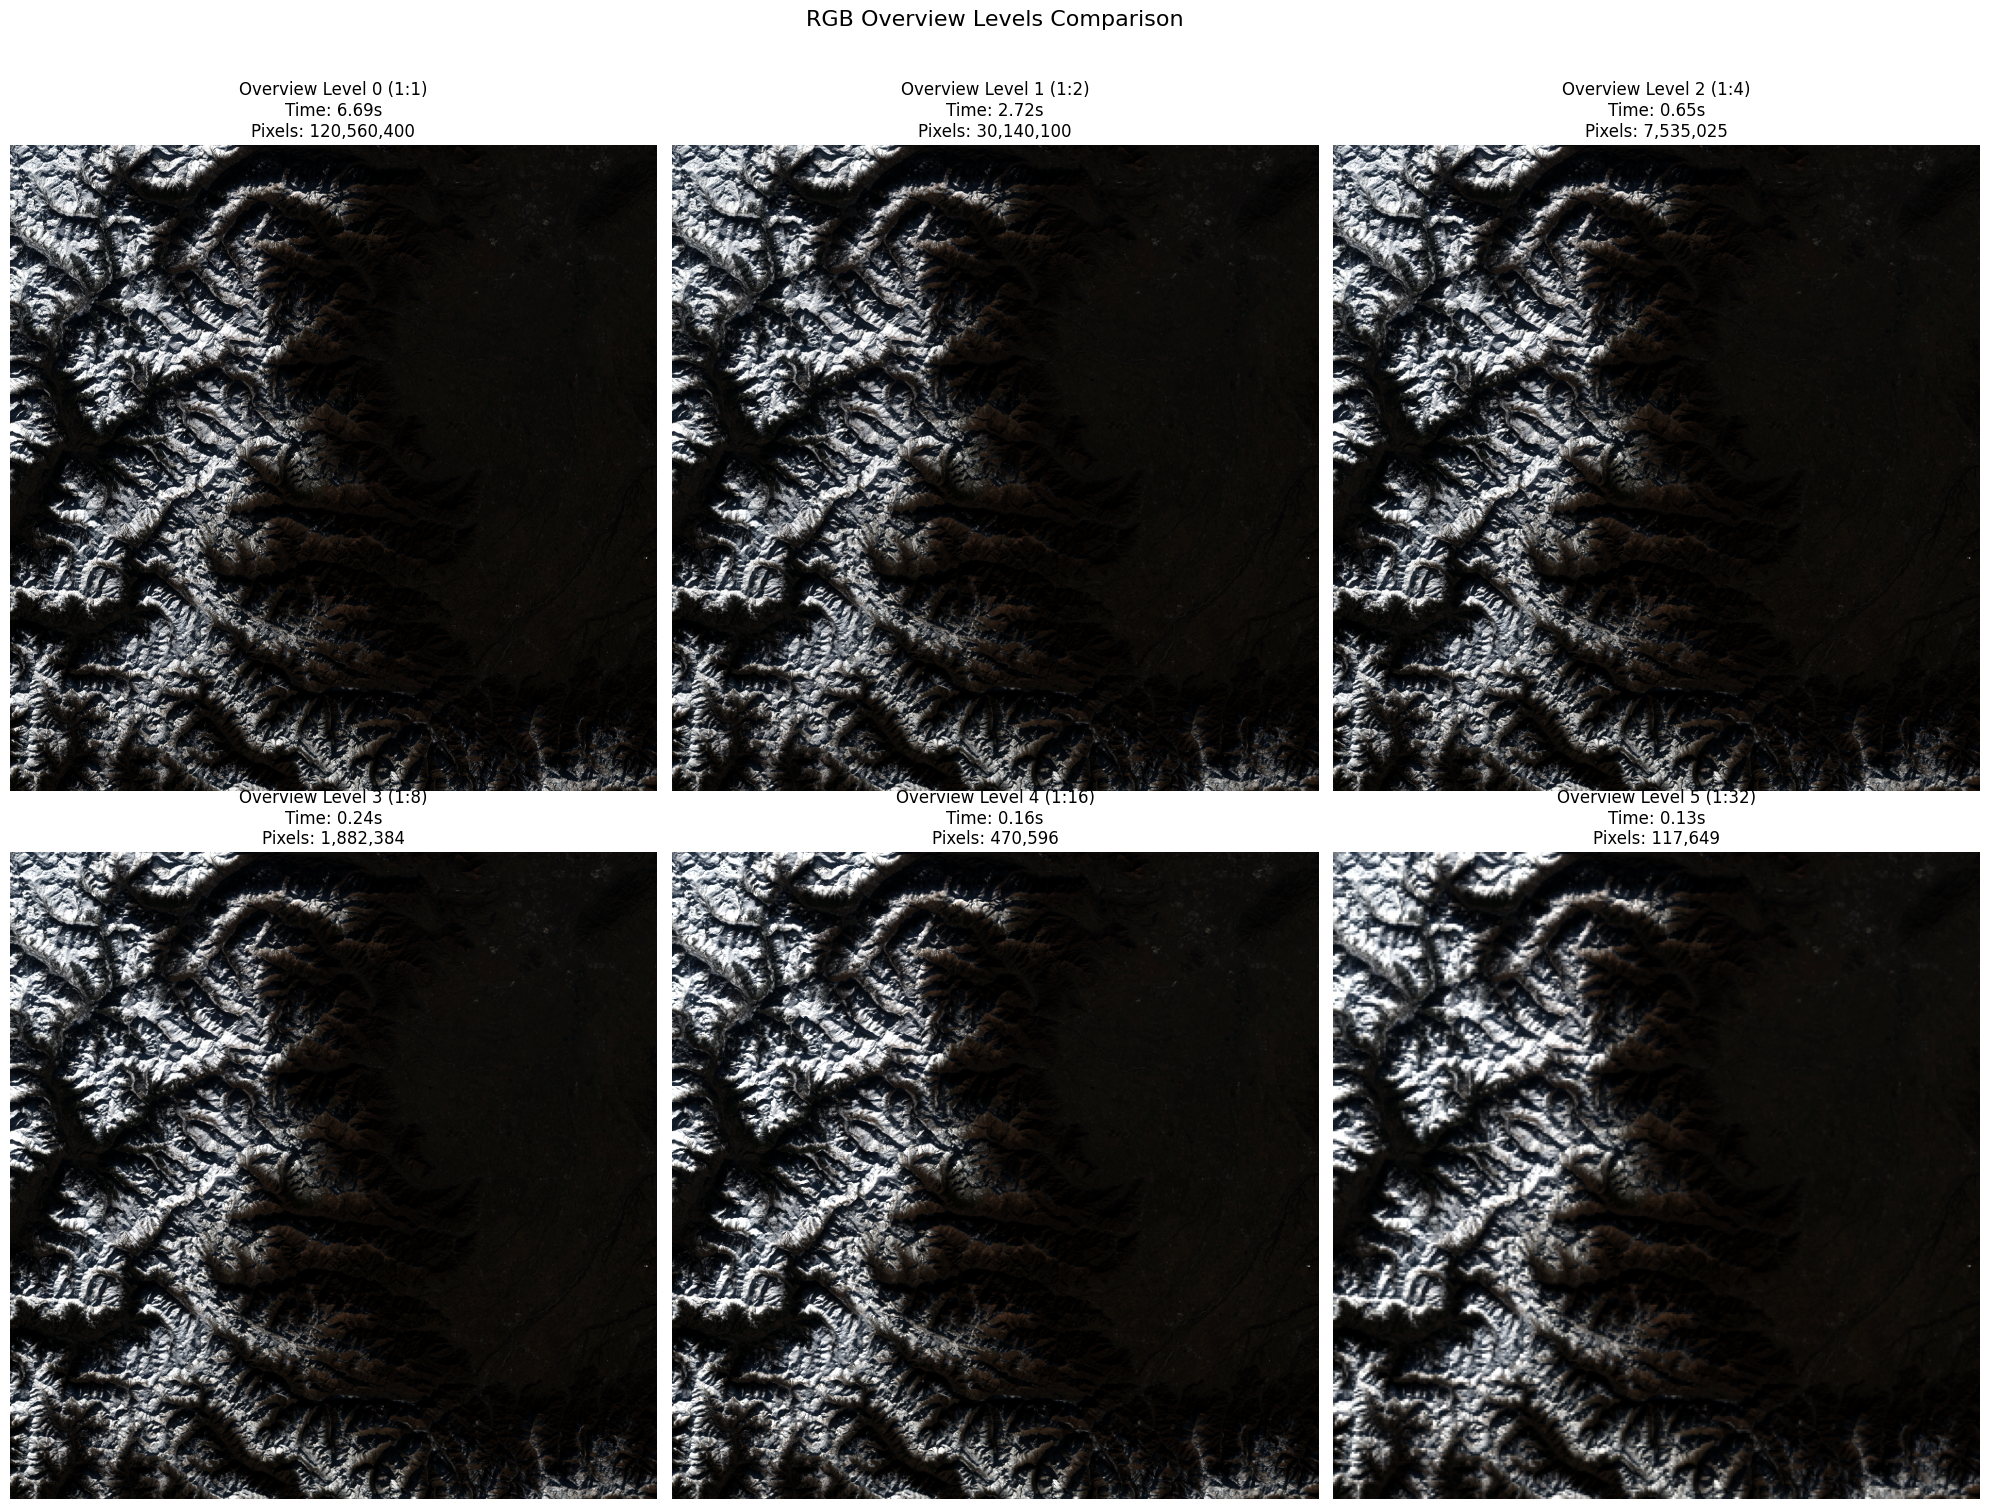

In [36]:
# Find the best resolution group for RGB visualization
rgb_group = None
for preferred_group in ['/measurements/reflectance/r10m', '/measurements/reflectance/r20m', '/measurements/reflectance/r60m']:
    if preferred_group in result['processed_groups']:
        available_bands = list(result['processed_groups'][preferred_group].data_vars)
        red_band, green_band, blue_band = get_sentinel2_rgb_bands(preferred_group)
        
        if all(band in available_bands for band in [red_band, green_band, blue_band]):
            rgb_group = preferred_group
            break

if rgb_group:
    print(f"Using {rgb_group} for RGB visualization")
    red_band, green_band, blue_band = get_sentinel2_rgb_bands(rgb_group)
    print(f"RGB bands: R={red_band}, G={green_band}, B={blue_band}")

    # Create figure for overview comparison and timing analysis
    fig = plt.figure(figsize=(20, 15))
    gs = plt.GridSpec(2, 3)
    
    # Plot overview levels 0-5 with processing times
    timing_data = []
    for i in range(6):  # 0 through 5
        ax = plt.subplot(gs[i//3, i%3])
        
        start_time = time.time()
        if i == 0:
            # Native resolution
            ds = xr.open_zarr(f"{v3_output}/{rgb_group}")
            red_data = ds[red_band].values
            green_data = ds[green_band].values
            blue_data = ds[blue_band].values
        else:
            # Overview level
            ds = xr.open_zarr(f"{v3_output}/{rgb_group}/{red_band}_overviews", group=str(i))
            red_data = ds[red_band].values
            ds = xr.open_zarr(f"{v3_output}/{rgb_group}/{green_band}_overviews", group=str(i))
            green_data = ds[green_band].values
            ds = xr.open_zarr(f"{v3_output}/{rgb_group}/{blue_band}_overviews", group=str(i))
            blue_data = ds[blue_band].values
        
        # Create RGB array and measure performance
        rgb_array = np.stack([red_data, green_data, blue_data], axis=-1)
        proc_time = time.time() - start_time
        pixel_count = rgb_array.shape[0] * rgb_array.shape[1]
        
        # Apply contrast stretching for better visualization
        rgb_stretched = np.zeros_like(rgb_array)
        for j in range(3):
            band = rgb_array[:, :, j]
            p_low, p_high = np.percentile(band[~np.isnan(band)], (2, 98))
            rgb_stretched[:, :, j] = np.clip((band - p_low) / (p_high - p_low), 0, 1)
        
        # Plot with performance metrics
        ax.imshow(rgb_stretched)
        scale = 2**i if i > 0 else 1
        ax.set_title(f'Overview Level {i} (1:{scale})\nTime: {proc_time:.2f}s\nPixels: {pixel_count:,}')
        ax.axis('off')
        
        # Store timing data for analysis
        timing_data.append({
            'level': i,
            'time': proc_time,
            'pixels': pixel_count
        })
    
    plt.suptitle('RGB Overview Levels Comparison', y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()


### Data Loading Performance Analysis

Now let's analyze the relationship between overview levels and data loading performance. This shows how overview levels affect the time needed to read and display the data:

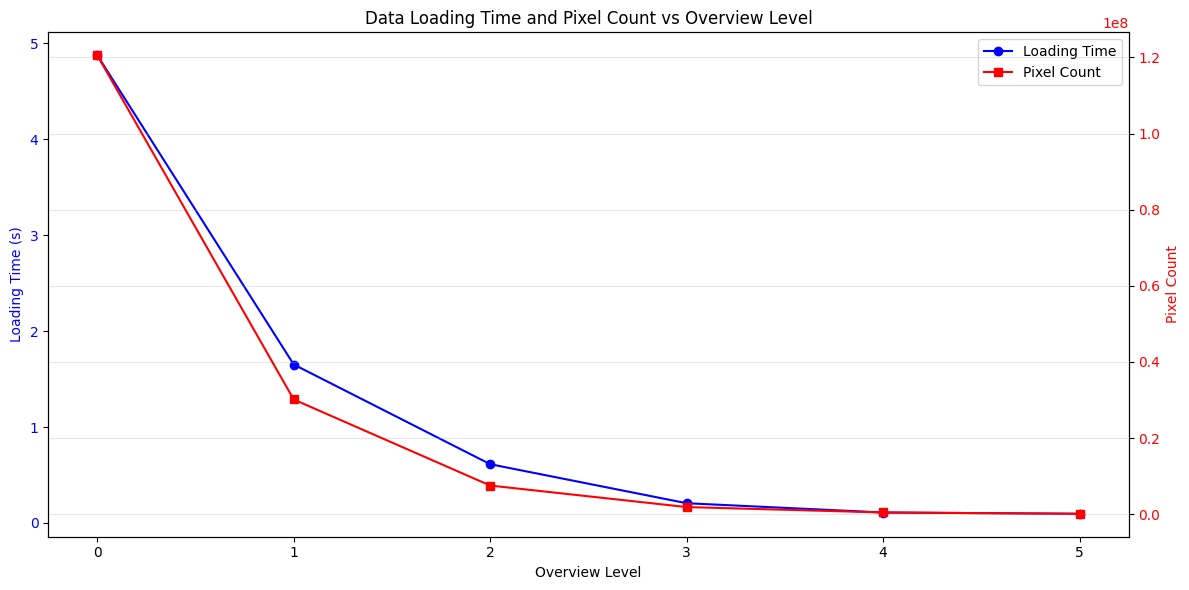

In [37]:
# Create performance analysis plot from the timing data
if rgb_group:
    plt.figure(figsize=(12, 6))
    
    # Plot processing time
    ax1 = plt.gca()
    line1 = ax1.plot(levels, times, 'b-o', label='Loading Time')
    ax1.set_xlabel('Overview Level')
    ax1.set_ylabel('Loading Time (s)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    
    # Plot pixel count on secondary y-axis
    ax2 = ax1.twinx()
    line2 = ax2.plot(levels, pixels, 'r-s', label='Pixel Count')
    ax2.set_ylabel('Pixel Count', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # Add legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.title('Data Loading Time and Pixel Count vs Overview Level')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


## Analysis and Interpretation

The visualization and data access analysis above reveals several key insights:

### 1. Data Access Performance
- Higher overview levels load much faster due to reduced data volume
- Loading efficiency improves significantly with each overview level
- Access time scales roughly with the number of pixels being read

### 2. Visual Quality vs Loading Speed Trade-off
- **Level 0 (Native)**: Full resolution, maximum detail
- **Level 1-2**: Good balance of detail and performance
- **Level 3-5**: Progressive reduction in detail, but still useful for overview purposes

### 3. Data Loading Characteristics
- **Access Time**: Decreases significantly with each overview level
  - Level 0 (native) has the highest loading time
  - Higher levels provide faster visualization
- **Pixel Count**: Decreases exponentially (1/4 with each level)
  - Directly affects data loading time
  - Determines memory requirements for visualization

### 4. Practical Applications
- **Interactive Visualization**: Use higher overview levels for initial display and navigation
- **Detailed Analysis**: Switch to lower overview levels when zoomed in
- **Memory Management**: Choose overview level based on available system resources

### 5. Access Efficiency
- Overview pyramids enable fast initial visualization
- Memory usage is optimized for each zoom level
- Progressive loading supports interactive exploration

This analysis demonstrates the value of having multiple overview levels, allowing applications to choose the appropriate level based on their specific needs for performance vs. detail.

## Technical Implementation Notes

The overview system implements several key features:

1. **Efficient Downsampling**
   - Uses block averaging for better quality
   - Preserves data characteristics across resolutions

2. **Coordinate System Handling**
   - Maintains proper georeferencing at all levels
   - Preserves CRS and transformation information

3. **Performance Optimizations**
   - Chunked storage for efficient access
   - Parallel processing capabilities
   - Memory-efficient processing of large datasets

4. **Standards Compliance**
   - Follows COG conventions for overviews
   - Compatible with GeoZarr specifications
   - Maintains EOPF structural requirements

These technical choices ensure the resulting dataset is both efficient and standards-compliant.